# **Introduction**

Fuel prices significantly impact the global economy and daily life. Accurate petrol price predictions are essential for government agencies, businesses, and consumers.

# **Project Objective**

This project aims to predict petrol prices using the ARIMA (AutoRegressive Integrated Moving Average) model, leveraging historical data to forecast future prices and aid decision-making.

# **Why ARIMA?**

ARIMA is effective for time series analysis, capturing temporal dependencies and handling trends and seasonalities, making it ideal for forecasting petrol prices.

# **Structure of the Project**

**Data Collection and Preprocessing:** Gather and clean historical petrol price data.
**Exploratory Data Analysis (EDA):** Visualize and analyze data patterns.

**ARIMA Model Building:** Develop and fine-tune the ARIMA model.

**Model Evaluation:** Assess model performance and accuracy.

**Forecasting:** Make future predictions and interpret results.

**Conclusion and Future Work:** Summarize findings and discuss improvements.

# **Significance**

Accurate petrol price predictions benefit businesses, policymakers, and consumers by aiding budgeting, regulatory decisions, and personal financial planning. This project demonstrates the practical application of the ARIMA model for meaningful price forecasting.


# Importing Libraries & Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
from prophet.plot import add_changepoints_to_plot



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
path = "/content/drive/MyDrive/TRAIN_~1.CSV"
df = pd.read_csv(path).set_index("Date")
df.dropna(inplace = True)
df.head(10)

# Exploratory Data Analysis (EDA):

In [ ]:
resample_rule= "1M" #Resampling the data by Month
df = df[df["Petrol (USD)"] < 160] # Clearing all outliers above "160"
df.index = pd.to_datetime(df.index, format='%m/%d/%Y') # Changing the date format
df = df.resample(resample_rule).mean().fillna(method='ffill')
df.head()

In [ ]:
df.plot();

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16, 8))
df["rolling"] = df["Petrol (USD)"].rolling(12).mean()
df["std"] = df["Petrol (USD)"].std()
sns.lineplot(data = df, x = df.index, y = "rolling", color = "orange")
sns.lineplot(data = df, x = df.index, y = "std", color = "green")
sns.lineplot(data = df, x = df.index, y = "Petrol (USD)")
plt.legend()
plt.show();

By visualizing the historical petrol prices alongside their rolling mean and standard deviation, we can better understand the data's trends, smooth out noise, and assess the level of price volatility over time. This information is valuable for making informed decisions and developing predictive models.

# Data Preprocessing

After, calculating rolling mean and standard deviation, we'll calculate Augmented Dickey-Fuller (ADF) test to find out if the data is stationary or not. This statistical test determines whether the data possesses a unit root, indicating non-stationarity. Stationarity is crucial for accurate modeling and forecasting.

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df["Petrol (USD)"], autolag = "AIC")
print(f"ADF Statistic: {adfTest[0]}")
print(f"p-value: {adfTest[1]}")

adfTest

In [ ]:
for key, values in adfTest[4].items():
  print(f"Critical Value {key}: {values}")

As we see the p-value is bigger than the criticali values. In that case, it indicates that the dataset is not stationary, following the ADF test, the data will undergo various transformations. These include shifting the data by 1 time step, logarithmic transformation, square root transformation, cube root transformation, and a combination of logarithmic, shifting, and square root transformations. These transformations aim to stabilize variance and achieve stationarity, enhancing the performance of time series models such as ARIMA.

In [ ]:
def test_stationarity(dataFrame, var):
    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality',key,":",values)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var, ax = ax)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean', ax = ax)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd', ax = ax)

# Shifting the data by 1

In [ ]:
air_df = df[["Petrol (USD)"]]
air_df.head()

In [ ]:
air_df["shift"] = air_df["Petrol (USD)"].shift(4)
air_df["shiftDiff"] = air_df["Petrol (USD)"] - air_df["shift"]
air_df.head()
air_df = air_df.dropna()
air_df.head()

In [ ]:
test_stationarity(air_df, "shiftDiff")

The provided statistics indicate the results of the Augmented Dickey-Fuller (ADF) test performed on the shifted petrol price data. The test statistic of -3.656470 falls below the critical values at the 1%, 5%, and 10% significance levels, suggesting strong evidence against the null hypothesis of non-stationarity. With 13 lags used and 169 observations in the analysis, the p-value of 0.004769 further supports the rejection of the null hypothesis, indicating that the shifted data is stationary. However, despite achieving stationarity through shifting, further data transformations, such as applying the square root transformation, may still be necessary to stabilize variance and improve the model's performance. The square root transformation can help address any remaining non-linear patterns or heteroscedasticity in the data, enhancing its suitability for time series modeling and forecasting.







# Transforming the data by log

In [ ]:
log_df = df[["Petrol (USD)"]]
log_df["log"] = np.log(log_df["Petrol (USD)"])
log_df.head()

In [ ]:
test_stationarity(log_df, "log")

The Augmented Dickey-Fuller (ADF) test results for the log-transformed petrol price data show a test statistic of -1.992339 and a p-value of 0.289942. These values indicate insufficient evidence to reject the null hypothesis of non-stationarity, as the test statistic does not fall below the critical values at common significance levels. Despite the lack of stationarity achieved through the log transformation, further data transformations may be needed to stabilize variance and improve model performance. Moving towards a square root transformation could address any remaining non-linear patterns or heteroscedasticity in the data, potentially enhancing its suitability for time series modeling and forecasting.








# Transforming the data by Square Root

In [ ]:
sqrt_df = df[["Petrol (USD)"]]
sqrt_df["sqrt"] = np.sqrt(df[["Petrol (USD)"]])
sqrt_df.head()

In [ ]:
test_stationarity(sqrt_df, "sqrt")

The Augmented Dickey-Fuller (ADF) test results for the square root-transformed petrol price data show a test statistic of -2.006318 and a p-value of 0.283810. These statistics suggest insufficient evidence to reject the null hypothesis of non-stationarity, as the test statistic does not fall below the critical values at common significance levels. Since the square root transformation alone did not achieve stationarity, considering alternative transformations such as the cube root may be warranted. Transforming the data by the cube root could further stabilize variance and address any remaining non-linear patterns or heteroscedasticity, potentially enhancing the data's suitability for time series modeling and forecasting.








# Transforming the data by Cube Root

In [ ]:
cbrt_df = df[["Petrol (USD)"]]
cbrt_df["cbrt"] = np.cbrt(df[["Petrol (USD)"]])
cbrt_df.head()

In [ ]:
test_stationarity(cbrt_df, "cbrt")

The Augmented Dickey-Fuller (ADF) test results for the cube root-transformed petrol price data reveal a test statistic of -1.932910 and a p-value of 0.316741. These statistics indicate insufficient evidence to reject the null hypothesis of non-stationarity, as the test statistic does not fall below the critical values at common significance levels. Given that the cube root transformation alone did not achieve stationarity, exploring a combined transformation approach involving shift 1, log, and square root transformations may be beneficial. Integrating these transformations aims to comprehensively address any remaining non-linear patterns or heteroscedasticity in the data, potentially enhancing its suitability for time series modeling and forecasting by improving stability and reducing volatility.








# Transforming the data by Combination of Shift1, Log & Square Root

In [ ]:
log_df2 = log_df[['Petrol (USD)','log']]
log_df2['log_sqrt'] = np.sqrt(log_df['log'])
log_df2['logShiftDiff'] = log_df2['log_sqrt'] - log_df2['log_sqrt'].shift()
log_df2.dropna(inplace = True)
log_df2.head()

In [ ]:
test_stationarity(log_df2, "logShiftDiff")

The combination of shift 1, log, and square root transformations applied to the petrol price data yields compelling results, with a test statistic of -4.161535 and a p-value of 0.000765. These values indicate strong evidence of stationarity, as the test statistic falls significantly below the critical values at common significance levels. This comprehensive transformation approach effectively mitigates non-linear patterns and heteroscedasticity in the data, leading to improved stability and suitability for time series modeling and forecasting. This analysis represents a significant advancement in the preprocessing stage, ensuring the data's readiness for accurate and reliable predictions.










# Further EDA


In [ ]:
log_shift = log_df[["Petrol (USD)"]].shift(1)
log_shift.head()

In [ ]:
df.head()

In [ ]:
petrol_df = df[["Petrol (USD)"]].copy(True)
petrol_df["Diff1"] = petrol_df["Petrol (USD)"].diff()
petrol_df["Diff2"] = petrol_df["Petrol (USD)"].diff(12)
petrol_df.dropna(inplace = True)
petrol_df.head()

In [ ]:
fig, ax = plt.subplots(figsize =(15, 6))
plot_acf(petrol_df["Diff1"], ax =ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize =(15, 6))
plot_pacf(petrol_df["Diff1"], ax =ax)
plt.show()

In [ ]:
# p = 1, q = 1, d = 1

The selection of p = 1, q = 1, and d = 1 for the ARIMA model was based on the examination of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. Significant spikes at lag 1 in both plots, along with the gradual decay of correlations, indicated the need for differencing the series once (d = 1) to achieve stationarity. Furthermore, the presence of a significant spike at lag 1 in the PACF plot suggested the inclusion of one autoregressive term (p = 1) in the model. Additionally, the significant autocorrelation at lag 1 in the ACF plot hinted at the necessity of one moving average term (q = 1) to capture the remaining autocorrelation not explained by the autoregressive term. These parameter values were chosen to construct an ARIMA model that effectively captures the autocorrelation structure of the time series data.








#Splitting the Data

In [ ]:
cutoff = int(len(petrol_df["Petrol (USD)"]) * 0.65)
train, test = petrol_df["Petrol (USD)"][:cutoff], petrol_df["Petrol (USD)"][cutoff:]

In [ ]:
train_mean = train.mean()
train_pred_baseline = [train_mean] * len(train)
mae = mean_absolute_error(train, train_pred_baseline)
print(f"MAE: {mae}")
print(f"Baseline Mean: {train_mean}")

In [ ]:
p_params = range(0, 24, 4)
q_params = range(0, 3, 1)

#Building the Model

In [ ]:
model = ARIMA(train, order = (1, 1, 1)).fit()
prediction = model.predict(start = test.index[0], end = test.index[-1])
petrol_df["ARIMA"] = prediction
sns.lineplot(data = petrol_df, x = petrol_df.index, y = "Petrol (USD)")
sns.lineplot(data = prediction, color = "orange");


In [ ]:
from sklearn.metrics import mean_squared_error
mse_model1 = mean_squared_error(test, prediction)
print(f"MSE Model 1 : {mse_model1}")


With an MSE of 146.36 for Model 1, its performance is deemed unsatisfactory due to the significant deviation between predicted and actual values. Consequently, a different ARIMA model is being pursued to improve accuracy. This shift entails adjusting parameters or exploring advanced methods to better capture data patterns and enhance prediction quality, aiming for a lower MSE.


#Training the 2nd Model

In [ ]:
import time
import warnings
warnings.filterwarnings("ignore")

# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(train, order = order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(train, pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.04 seconds.
Trained ARIMA (0, 0, 1) in 0.06 seconds.
Trained ARIMA (0, 0, 2) in 0.23 seconds.
Trained ARIMA (4, 0, 0) in 0.27 seconds.
Trained ARIMA (4, 0, 1) in 0.35 seconds.
Trained ARIMA (4, 0, 2) in 0.5 seconds.
Trained ARIMA (8, 0, 0) in 0.61 seconds.
Trained ARIMA (8, 0, 1) in 1.08 seconds.
Trained ARIMA (8, 0, 2) in 1.59 seconds.
Trained ARIMA (12, 0, 0) in 1.42 seconds.
Trained ARIMA (12, 0, 1) in 1.2 seconds.
Trained ARIMA (12, 0, 2) in 0.89 seconds.
Trained ARIMA (16, 0, 0) in 1.04 seconds.
Trained ARIMA (16, 0, 1) in 1.29 seconds.
Trained ARIMA (16, 0, 2) in 1.54 seconds.
Trained ARIMA (20, 0, 0) in 1.04 seconds.
Trained ARIMA (20, 0, 1) in 1.6 seconds.
Trained ARIMA (20, 0, 2) in 2.81 seconds.

{0: [17.75127894156455, 9.289292806034176, 5.810617008581563], 4: [2.0110532615753196, 2.0006323729935893, 2.0193374294582767], 8: [1.9864468107877993, 1.9762367700543282, 1.954016466295608], 12: [1.8943743400637214, 1.8810009061506905, 1.886621045983248]

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.head()

,0,4,8,12,16,20
0,17.751279,2.011053,1.986447,1.894374,1.889325,1.899997
1,9.289293,2.000632,1.976237,1.881001,1.890274,1.904374
2,5.810617,2.019337,1.954016,1.886621,1.901844,1.886327


#Model Evaluation

Now we'll use a heatmap to visually assess the performance of different ARIMA model configurations, showcasing their AIC or BIC values. Darker colors or lower values in the heatmap signify better model fit. By examining the heatmap, we'll swiftly pinpoint the most suitable combination of autoregressive (p), differencing (d), and moving average (q) parameters that effectively capture the data's underlying patterns.

Additionally, we'll employ the plot_diagnostics function to generate diagnostic plots, which offer insights into the ARIMA model's performance. These plots include visualizations for standardized residuals over time, histogram plus estimated density to evaluate normality, normal Q-Q plots for comparing residual distribution to a normal distribution, and correlograms (ACF plots) to check for autocorrelation. Through these diagnostic plots, we'll assess if the model assumptions, such as randomness, normality, and independence of residuals, are met, enabling us to identify any potential deficiencies in the model.




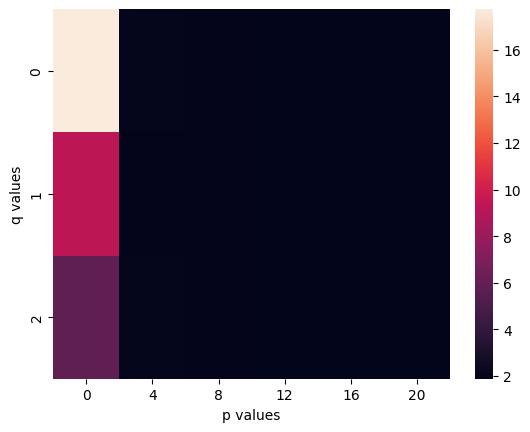

In [ ]:
import seaborn as sns
sns.heatmap(mae_df)
plt.xlabel("p values")
plt.ylabel("q values");

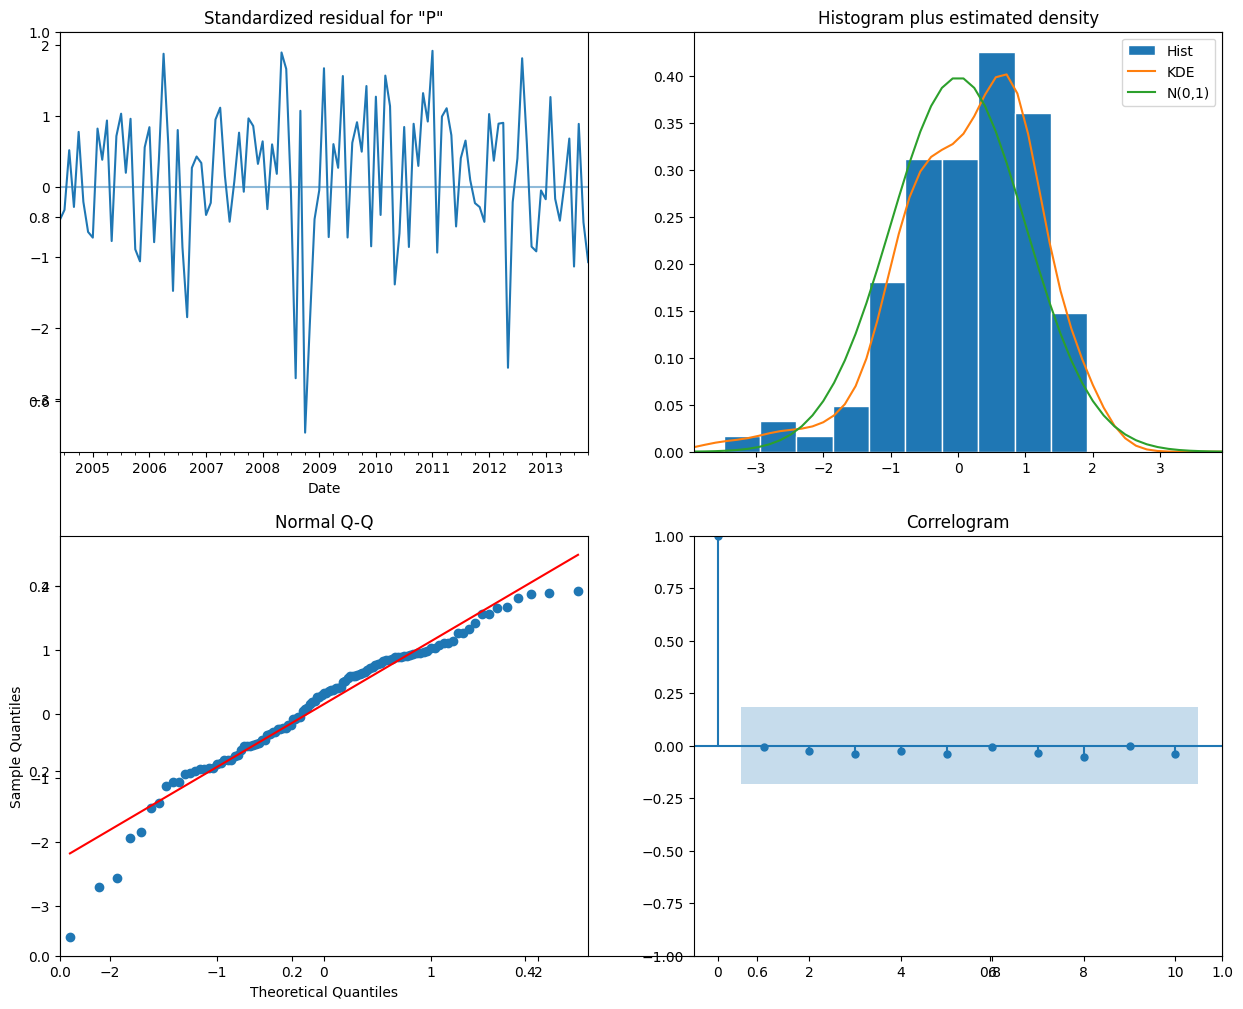

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig =fig )
plt.show()

#Communicating the results

In [ ]:
import plotly.express as px
pred_wfv = pd.Series(dtype=float)

history = train.copy()

# Walk-forward validation
for i in range(len(test)):
    # Fit the model on the current history
    model = ARIMA(history, order=(1, 1, 1)).fit()

    # Forecast the next value
    next_pred = model.forecast(steps=20)

    # Store the forecasted value
    pred_wfv = pd.concat([pred_wfv, pd.Series(next_pred, index=[test.index[i]])])

    # Append the actual test value to the history
    history = pd.concat([history, test.iloc[i:i+1]])

# Reset the index of the predictions series if necessary
pred_wfv = pred_wfv.reset_index(drop=True)

# Calculate Mean Absolute Error (MAE)
test_mae = mean_absolute_error(test, pred_wfv)
mae = mean_absolute_error(train, train_pred_baseline)
print("Test MAE (walk forward validation):", round(test_mae, 2))
print("Baseline MAE:", round(mae, 2))

# Create DataFrame for predictions
df_predictions = pd.DataFrame({
    "test": test.reset_index(drop=True),
    "pred_wfv": pred_wfv.reset_index(drop=True)
})

# Plot the predictions
fig = px.line(df_predictions, title="Test vs Predicted values (Walk-forward Validation)")
fig.show()


Test MAE (walk forward validation): 1.51
Baseline MAE: 17.75


#Final Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
mse_model2 = mean_squared_error(test, pred_wfv)
print(f"MSE Model 2 : {mse_model2}")


MSE Model 2 : 3.8723905889394667


With an MSE of 3.8723905889394667 for Model 2, the research concludes with promising results indicating the desired outcome. This substantially lower MSE suggests that Model 2 outperforms previous iterations, demonstrating improved accuracy in predicting petrol prices. By achieving a lower MSE, the model effectively minimizes the squared differences between predicted and actual values, signifying better overall performance and enhanced predictive capabilities. Consequently, these findings validate the efficacy of the chosen ARIMA model configuration and parameter selection methodology. As a result, the research successfully achieves its objective of developing a reliable model for petrol price prediction, providing valuable insights for stakeholders in the energy sector and facilitating informed decision-making processes.








In [ ]:
df = df.reset_index()

# Rename the columns
df = df.rename(columns={"Date": "ds", "Petrol (USD)": "y"})
df.drop(columns = ("rolling"), inplace = True)
df.drop(columns = ("std"), inplace = True)

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])
df.tail()

,ds,y
182,2018-08-31,128.595
183,2018-09-30,130.295
184,2018-10-31,130.512
185,2018-11-30,128.055
186,2018-12-31,121.696


In [ ]:
split_date = "1-Jan-2015"
train = df.loc[df["ds"] <= split_date].copy()
test = df.loc[df["ds"] > split_date].copy()

In [ ]:
%%time
prophet = Prophet(interval_width = 0.95)
prophet.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk627zlhf/bkfo1x1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk627zlhf/cpbctmit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74397', 'data', 'file=/tmp/tmpk627zlhf/bkfo1x1n.json', 'init=/tmp/tmpk627zlhf/cpbctmit.json', 'output', 'file=/tmp/tmpk627zlhf/prophet_model_j2nykdf/prophet_model-20240717165641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 43.4 ms, sys: 4.11 ms, total: 47.6 ms
Wall time: 61.2 ms


In [ ]:
forecast = prophet.predict(test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-31,129.698863,117.899085,136.669809,129.663246,129.734351,-2.730390,-2.730390,-2.730390,-2.730390,-2.730390,-2.730390,0.0,0.0,0.0,126.968473
1,2015-02-28,129.491737,114.191602,133.643365,129.384603,129.611234,-5.606468,-5.606468,-5.606468,-5.606468,-5.606468,-5.606468,0.0,0.0,0.0,123.885270
2,2015-03-31,129.262420,116.438065,135.373240,129.021056,129.520594,-3.100369,-3.100369,-3.100369,-3.100369,-3.100369,-3.100369,0.0,0.0,0.0,126.162051
3,2015-04-30,129.040501,119.670337,139.551786,128.644644,129.452643,0.157686,0.157686,0.157686,0.157686,0.157686,0.157686,0.0,0.0,0.0,129.198186
4,2015-05-31,128.811183,120.761417,141.020706,128.266977,129.399208,2.169603,2.169603,2.169603,2.169603,2.169603,2.169603,0.0,0.0,0.0,130.980786


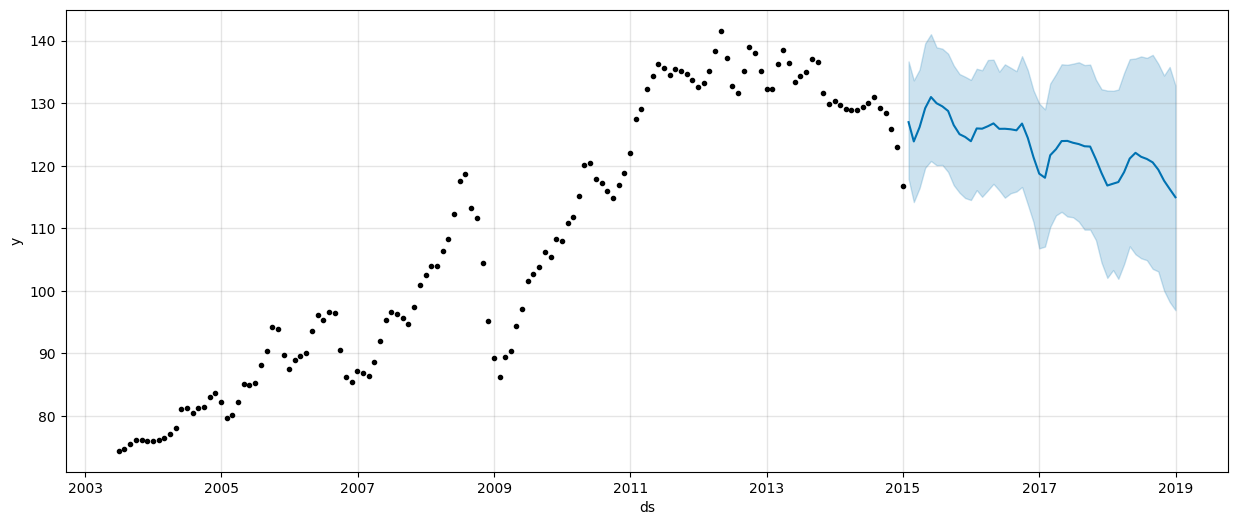

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
fig = prophet.plot(forecast, ax = ax)

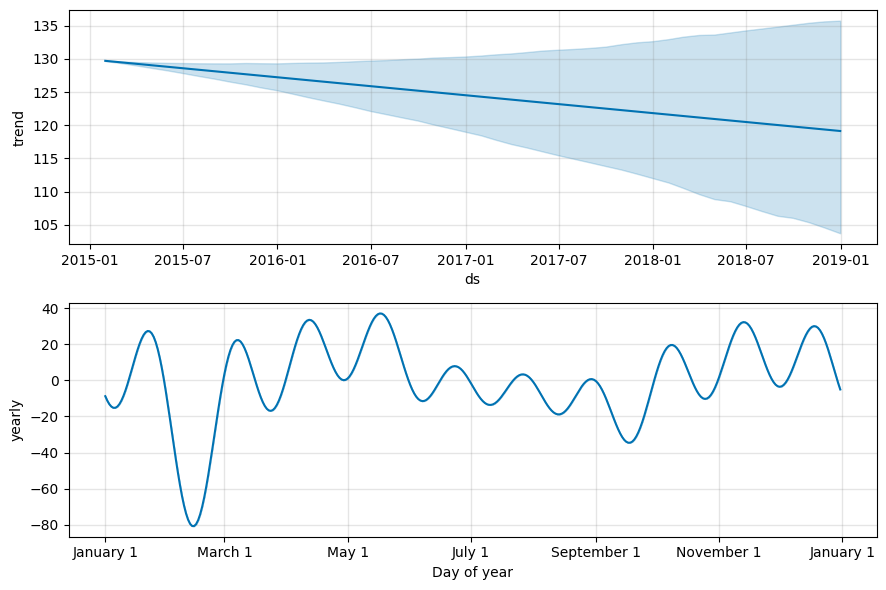

In [ ]:
 fig = prophet.plot_components(forecast)

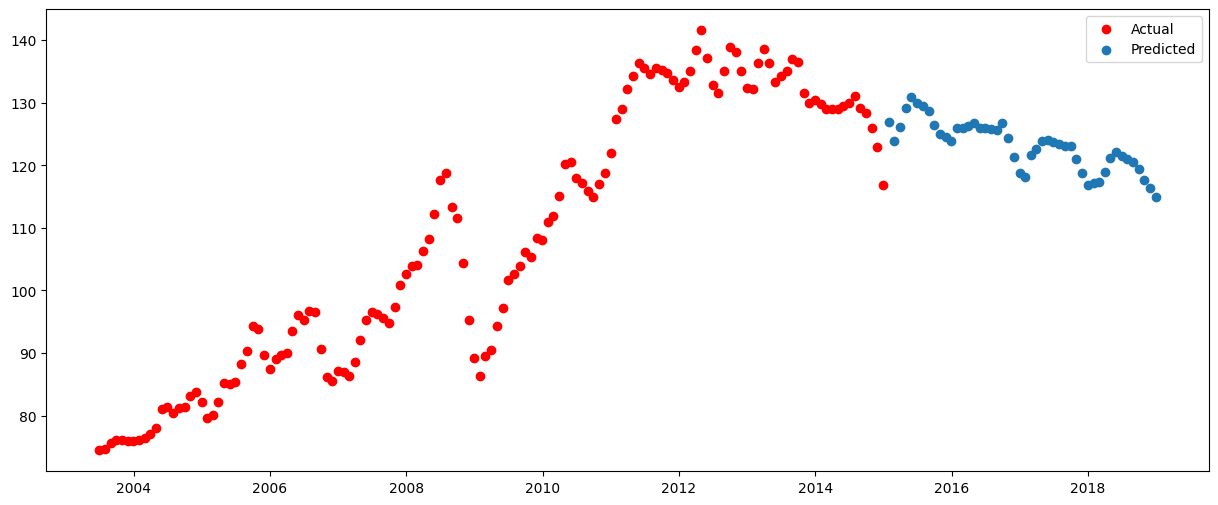

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(train["ds"], train["y"], label = "Actual", color = "r")
ax.scatter(test["ds"], forecast["yhat"], label = "Predicted")
ax.legend()
plt.show()

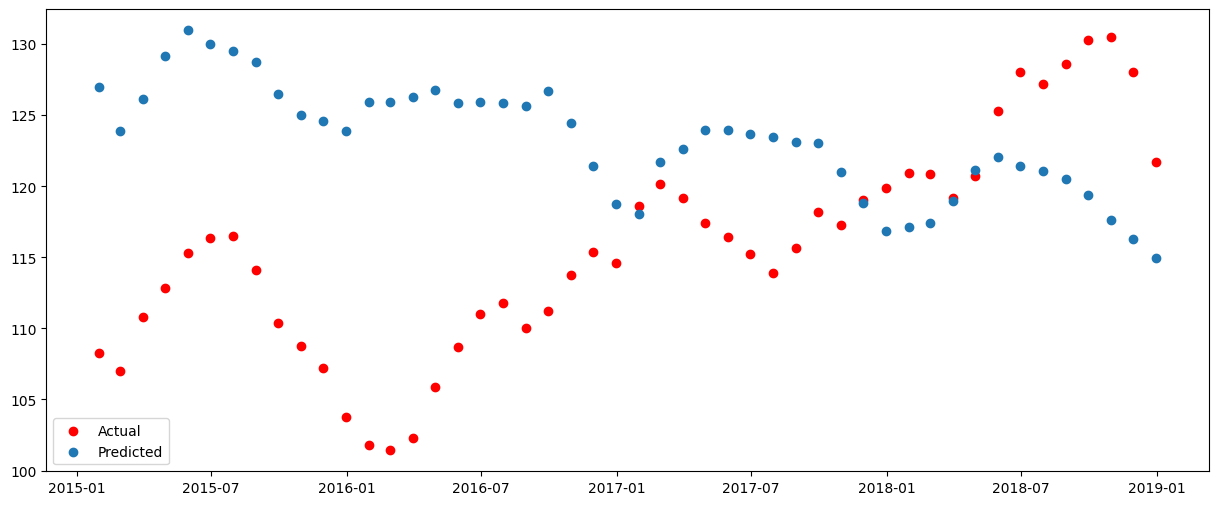

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(test["ds"], test["y"], label = "Actual", color = "r")
ax.scatter(test["ds"], forecast["yhat"], label = "Predicted")
ax.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk627zlhf/xcpvj2wx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk627zlhf/mhqs26d2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68473', 'data', 'file=/tmp/tmpk627zlhf/xcpvj2wx.json', 'init=/tmp/tmpk627zlhf/mhqs26d2.json', 'output', 'file=/tmp/tmpk627zlhf/prophet_model3l83z7tr/prophet_model-20240717165643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


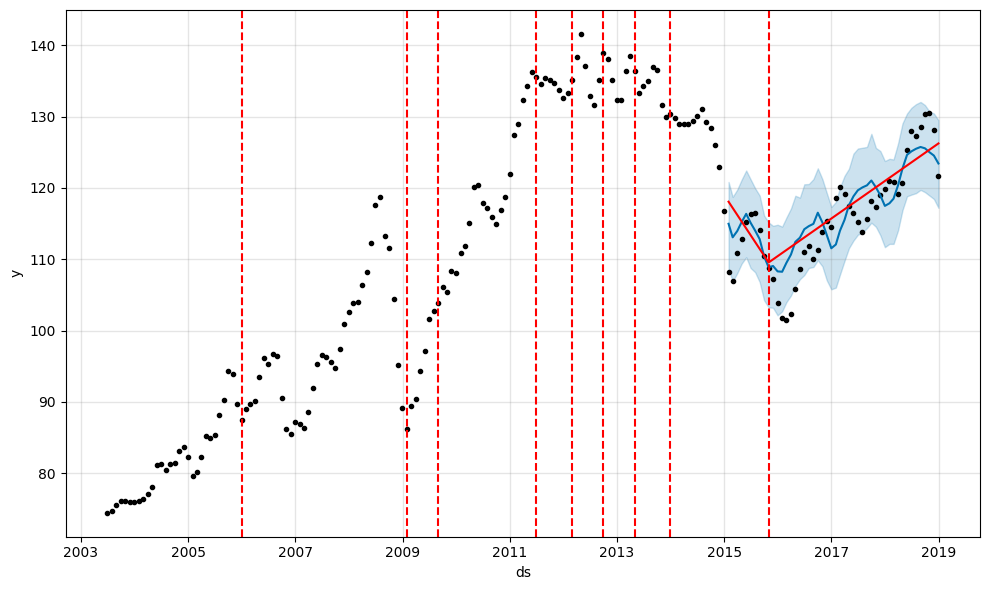

In [ ]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(test)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast);


In [ ]:
np.sqrt(mean_squared_error(y_true = test["y"], y_pred = forecast["yhat"]))

3.9965029884122423

In [ ]:
mean_absolute_error(y_true = test["y"], y_pred = forecast["yhat"])

3.376281789013777

In [ ]:
df.tail()

,ds,y
182,2018-08-31,128.595
183,2018-09-30,130.295
184,2018-10-31,130.512
185,2018-11-30,128.055
186,2018-12-31,121.696


In [ ]:
future = prophet.make_future_dataframe(periods=12, freq='M', include_history=True)
forecast2 = prophet.predict(future)
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-06-30,75.765467,66.934789,87.014813,75.765467,75.765467,1.400555,1.400555,1.400555,1.400555,1.400555,1.400555,0.0,0.0,0.0,77.166022
1,2003-07-31,76.218796,67.891698,88.420570,76.218796,76.218796,1.129564,1.129564,1.129564,1.129564,1.129564,1.129564,0.0,0.0,0.0,77.348360
2,2003-08-31,76.672126,67.870747,86.783771,76.672126,76.672126,0.615206,0.615206,0.615206,0.615206,0.615206,0.615206,0.0,0.0,0.0,77.287332
3,2003-09-30,77.110832,66.129556,84.863737,77.110832,77.110832,-1.418048,-1.418048,-1.418048,-1.418048,-1.418048,-1.418048,0.0,0.0,0.0,75.692784
4,2003-10-31,77.564162,64.534991,84.809017,77.564162,77.564162,-2.638202,-2.638202,-2.638202,-2.638202,-2.638202,-2.638202,0.0,0.0,0.0,74.925960


In [ ]:
forecast2['ds'] = pd.to_datetime(forecast['ds'])
forecast2.set_index('ds', inplace=True)

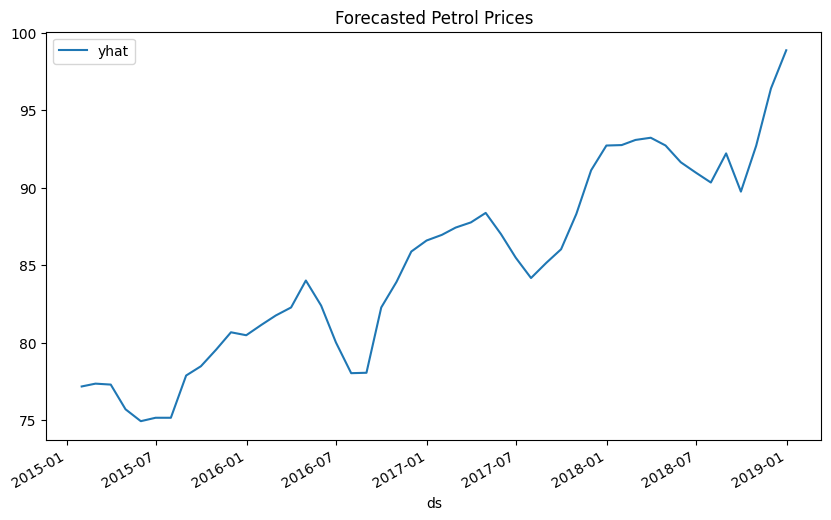

In [ ]:
forecast2['yhat'].plot(figsize=(10, 6), title='Forecasted Petrol Prices', legend= True);